In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd


In [22]:
# Define multi-scale convolution block
def multi_scale_conv_block(x, filters):
    conv_5x5 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x)
    conv_7x7 = layers.Conv2D(filters, (7, 7), padding='same', activation='relu')(x)
    
    # Concatenate the outputs of the two convolutions
    concatenated = layers.Concatenate()([conv_5x5, conv_7x7])
    
    # Apply 1x1 convolution to combine the features
    conv_1x1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(concatenated)
    
    # Apply batch normalization and ReLU activation
    output = layers.BatchNormalization()(conv_1x1)
    output = layers.ReLU()(output)
    
    return output


In [23]:
# Define the full model architecture
def build_model(input_shape=(18, 18, 6)):
    inputs = layers.Input(shape=input_shape)
    x = multi_scale_conv_block(inputs, 16)
    x = multi_scale_conv_block(x, 32)
    x = multi_scale_conv_block(x, 64)
    x = multi_scale_conv_block(x, 128)
    x = layers.GlobalAveragePooling2D()(x)  # Replace max pooling with global average pooling
    outputs = layers.Dense(4, activation='softmax')(x)  # Assuming 4 output classes: 0, 1, 2, 3
    
    model = models.Model(inputs, outputs)
    return model

In [24]:
# Cosine annealing learning rate scheduler
def cosine_annealing(epoch, initial_lr=0.001, total_epochs=150):
    return initial_lr * (0.1 + 0.5 * (1 + np.cos(np.pi * epoch / total_epochs)))


In [25]:
# Training setup
def train_model(df, epochs=150, batch_size=640):
    # Prepare data for training
    X = np.stack(df['input_matrix'].values)  # Shape: (num_samples, 18, 18, 6)
    y = tf.keras.utils.to_categorical(df['label'], num_classes=4)  # One-hot encoding of labels

    # Define 10-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_accuracies = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = build_model()
        model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Set up learning rate scheduler
        lr_scheduler = LearningRateScheduler(lambda epoch: cosine_annealing(epoch, initial_lr=0.001, total_epochs=epochs))
        
        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[lr_scheduler],
            verbose=1
        )
        
        # Evaluate and save the accuracy of this fold
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        fold_accuracies.append(val_accuracy)
        print(f"Fold accuracy: {val_accuracy * 100:.2f}%")

    # Calculate average accuracy over all folds
    average_accuracy = np.mean(fold_accuracies)
    print(f"Average accuracy over 10 folds: {average_accuracy * 100:.2f}%")

# Load the preprocessed dataset

In [26]:

# Load the labels
labels = pd.read_csv('dataset/labels.csv')

# Load the input_matrix
input_matrix_array = np.load('dataset/input_matrix.npy')

# Reconstruct the DataFrame
train_df= pd.DataFrame({'input_matrix': list(input_matrix_array), 'label': labels['label']})

In [27]:
train_df.head()

,input_matrix,label
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",2
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",3
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",3
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",0
4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0...",0


(18, 18, 6)


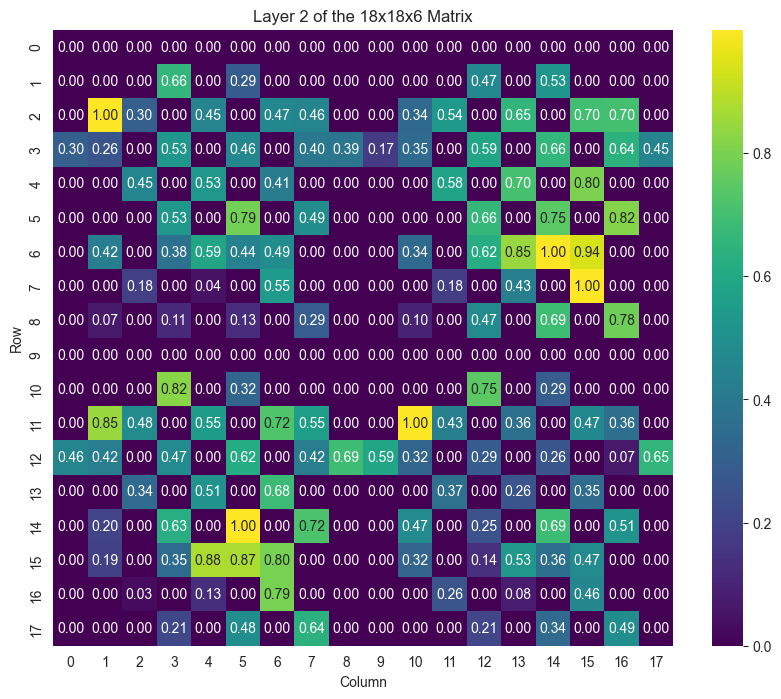

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

input_mat = train_df['input_matrix'][0]
print(input_mat.shape)
# Choose the layer to plot, e.g., layer 0
layer = 2
matrix_layer = input_mat[:, :, layer]

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(matrix_layer, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title(f"Layer {layer} of the 18x18x6 Matrix")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()

In [ ]:
train_model(train_df)

Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.2954 - loss: nan - val_accuracy: 0.3182 - val_loss: nan - learning_rate: 0.0011
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.3098 - loss: nan - val_accuracy: 0.3182 - val_loss: nan - learning_rate: 0.0011
Epoch 3/150
2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.3133 - loss: nan